# Taxi Driving with Q-Learning

In [ ]:
!pip install gym

In [ ]:
import gym
import numpy as np
import random
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

## The link to the OpenAI implementation of the environment: https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py

### Inherits from "DiscreteEnv" class: https://github.com/openai/gym/blob/master/gym/envs/toy_text/discrete.py

#### For non-discrete, non-deterministic generic environment check out: https://github.com/openai/gym/blob/a5a6ae6bc0a5cfc0ff1ce9be723d59593c165022/gym/core.py#L8

In [ ]:
# This provides functions for reset, storing observation state + action state, step function, etc.

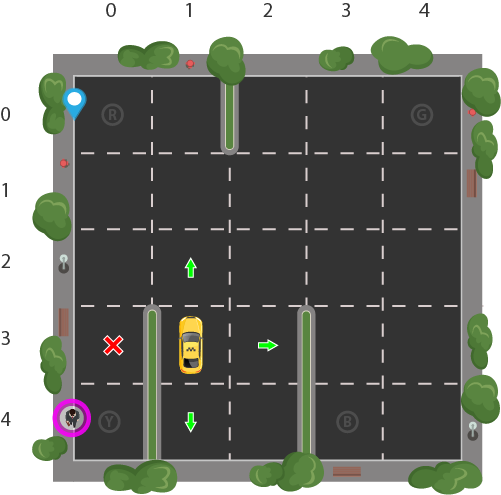

In [ ]:
Image(filename='taxi_env.png')

In [ ]:
env = gym.make("Taxi-v3")
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
# resets environment to new random state
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
state_size = env.observation_space.n
action_size = env.action_space.n

print(env.observation_space)
print(env.action_space)

Discrete(500)
Discrete(6)


In [ ]:
# hard coded pickup and drop off locations.
env.locs

[(0, 0), (0, 4), (4, 0), (4, 3)]

In [ ]:
state = env.encode(3, 1, 3, 1) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.env.s = state
env.render()

State: 333
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
# note that passenger index == 4 means the passenger is in the taxi.

state = env.encode(0, 0, 0, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.env.s = state
env.render()

State: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
# all possible states, with rewards and actions. Look at documentation to see how they build this. 
# P[state][action] = (1.0, new_state, reward, done) 

env.P[0]

{0: [(1.0, 100, -1, False)],
 1: [(1.0, 0, -1, False)],
 2: [(1.0, 20, -1, False)],
 3: [(1.0, 0, -1, False)],
 4: [(1.0, 16, -1, False)],
 5: [(1.0, 0, -10, False)]}

In [ ]:
# 4 possible ending states: passenger in taxi AND taxi at correct drop-off location AND choosing drop off action. 
env.P[16]

{0: [(1.0, 116, -1, False)],
 1: [(1.0, 16, -1, False)],
 2: [(1.0, 36, -1, False)],
 3: [(1.0, 16, -1, False)],
 4: [(1.0, 16, -10, False)],
 5: [(1.0, 0, 20, True)]}

In [ ]:
# One step 
env.reset()
action = env.action_space.sample() # your agent here (this takes random actions)
observation, reward, done, info = env.step(action)

state = env.s

print(f'Starting state: {state}')
env.env.s = state
env.render()

print(f'Action Taken: {action}')
print('\n')

print(f'Next State: {observation}')
env.env.s = observation
env.render()

print(f'Reward: {reward}')
print(f'Dropped Off Succesfully?: {done}')

env.close()


Starting state: 64
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Action Taken: 2


Next State: 64
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Reward: -1
Dropped Off Succesfully?: False


# Random Policy: OpenAI Gym

In [ ]:
done = False
frames = []
penalties = 0

num_actions = 100

# run random policy for a number of actions
for i in range(num_actions):
    
    # taking steps with random actions
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

In [ ]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame.get('frame'))
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 100
State: 224
Action: 5
Reward: -10


# Q-Learning

In [ ]:
## Setting Hyperparameter State:
total_episodes = 10000        # Total episodes
learning_rate = 0.5           # Learning rate
gamma = 0.5                   # Discounting rate
epsilon = 0.2                 # Exploration rate

Q = np.zeros((state_size, action_size))
print(Q.shape)
Q

# we are learning from this many episodes of experience
for episode in tqdm(range(total_episodes)):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    while not done:
        explore = random.uniform(0,1)

        ## If explore > epsilon, exploit
        if explore > epsilon:
            action = np.argmax(Q[state,:]) # arg max gets us the highest Q value

        # Else explore, pick a random new action
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr * [reward(s,a) + gamma * max Q(s',a') - Q(s,a)]
        td_target = reward + gamma * (np.max(Q[new_state, :]) - Q[state, action]) # recall the np.max is the Greedy Q-Learning method
        Q[state, action] = Q[state, action] + learning_rate * td_target

        # Our new state is state
        state = new_state

        # If done : finish episode
        if done == True:
            break

print(Q)

(500, 6)


100%|██████████| 10000/10000 [00:12<00:00, 791.30it/s]

[[  0.           0.           0.           0.           0.
    0.        ]
 [ 17.97982803  19.99972397  17.99988398  19.99700255  22.
    1.999501  ]
 [ 25.99990918  27.9979753   25.99927002  27.99980037  30.
    9.99996525]
 ...
 [  4.56399759  31.9930111    4.74501529  -3.83635637 -15.71247539
   -5.        ]
 [  0.35759384   9.44005221  -2.87910586  23.92746794 -12.53125
   -3.26445397]
 [ 24.21285841  25.69431382  15.18749699  38.           5.06247949
    0.74923259]]


Now that we have run the taxi game for many episodes of experience, we will run the Q-learning based policy to "play the game" with an AI agent. 

In [ ]:
env.reset()
rewards = []
frames = []

for episode in range(100):
    state = env.reset()
    done = False
    total_rewards = 0
    
    # one episode: from env.reset() to terminal state (done == True)
    while not done:
        # Take the action (index) that have the maximum expected future reward given that state
        # note that the random policy is gone, no exploration as we are just running our learned policy
        
        action = np.argmax(Q[state,:])
        new_state, reward, done, info = env.step(action)

        # storing output
        total_rewards += reward
        
        frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        })

        if done:
            rewards.append(total_rewards)
            steps = []
            #print ("Score", total_rewards)
            
            break
            
        state = new_state
env.close()  

In [ ]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 579
State: 309
Action: 0
Reward: -1


KeyboardInterrupt: ignored

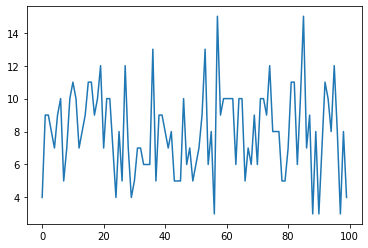

In [ ]:
plt.plot(rewards)

# Lab 10 - Deep Q-Learning with Neural Nets and Cart Pole Game

## Why Neural Networks ?

Q-learning fills up the state-value table $Q(s,a)$ by experience. In a world with tons of actions and states (millions), we cannot feasibly learn every Q for each state-action. 

But, we still want to use the state-value idea to pick the best policy (action to take in each state). 

So, we say $Q(s,a)$ and $V(s)$ can be represented as **functions** that map states and actions to values (rewards). If states and actions can be treated as mathematical "spaces," we can learn these functions (a function like $Q(s,a) = s^2 + 2*a + 5$, but obviously more complex) to run when we encounter a state and action to avoid storing a huge table of $Q$s, as well as allowing us to generalize to state-action pairs we maybe haven't observed.

Neural Networks are great **function approximators** so we use them to learn $Q(s,a)$ and $V(s)$ given some $(s,r,a)$ observations. They are not the only approximators (tree algorithms, linear combinations, etc.) but are *universal*, and use *gradients* to learn quickly, and commonly used. 

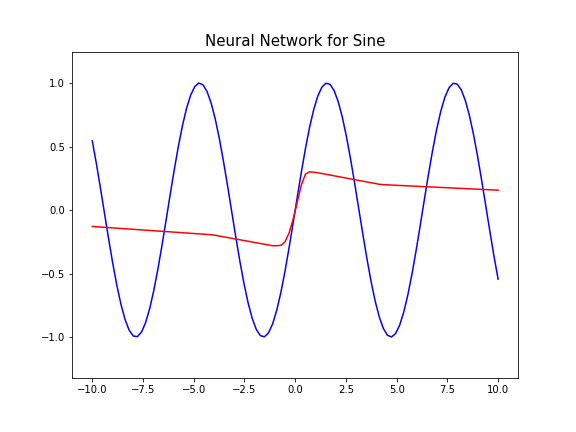

In [ ]:
# Neural Networks start from random weights and learn weights to approximate a Sin Function using data points from y = Sin(x)
from IPython.display import Image
Image(open('nn_sine.gif','rb').read())

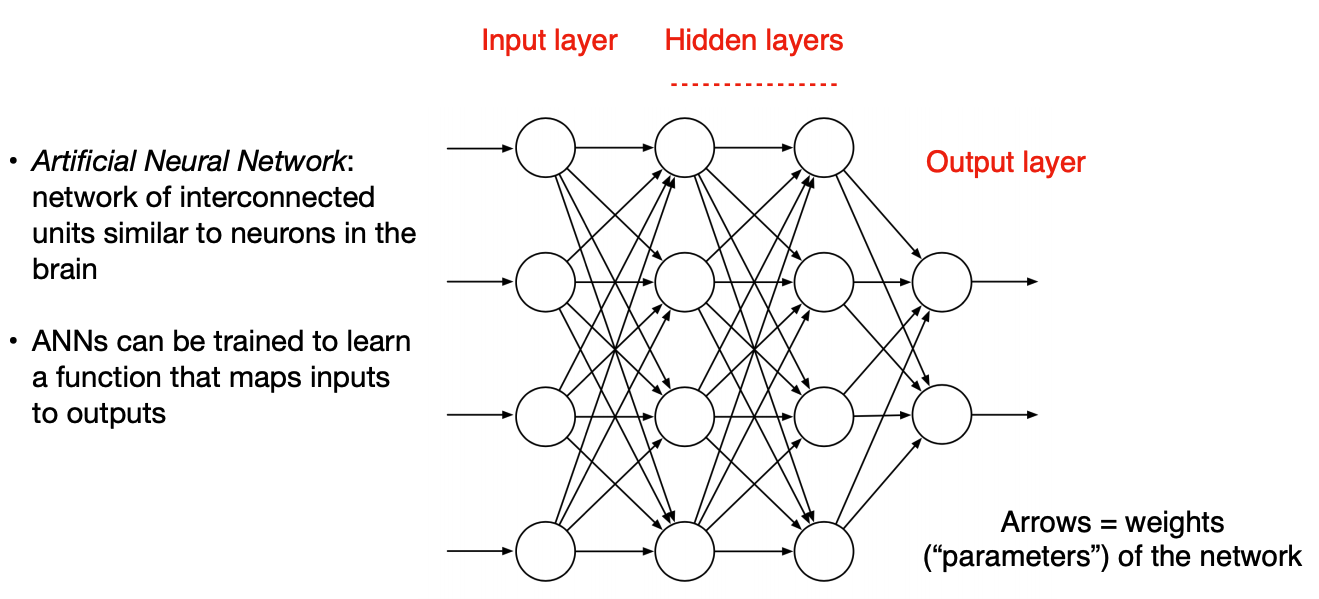

In [ ]:
Image('ANN.png')

## The Deep Q-Learning Algorithm

Recall how in Q-Learning we want to run through the environment and use experience of getting rewards from taking actions in states to learn the value of being in each state $V(s)$ and the action-value of each state $Q(s,a)$. Once we've learned a $Q^*(s,a)$ (with some epsilon exploration), it determines what action to take in each state, our policy:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

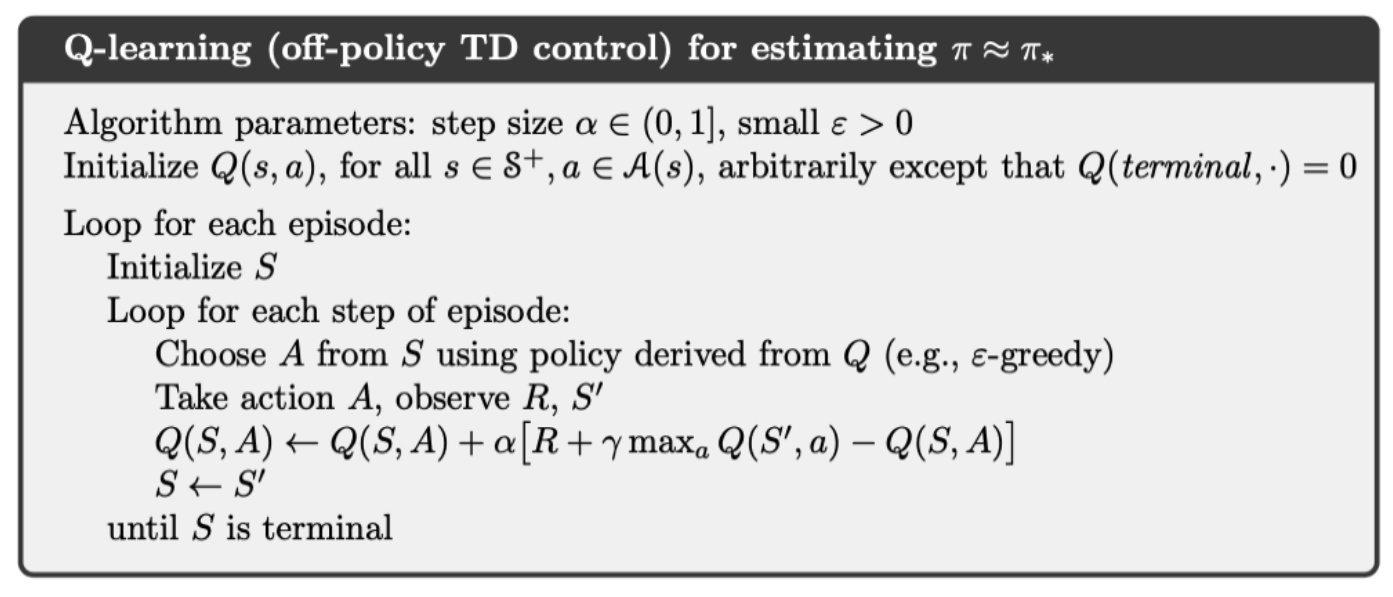

In [ ]:
Image(filename='QLearning.png')

However, if it would take too many loops to learn each $Q(s,a)$ because there are millions, billion of state-action combinaitons. Recall in taxi there were only 500, real driving is not discrete actions but continuous (infinite) angles you could turn at, continuous speeds, millions of destinations, etc. So it is not easy to learn each value of $Q(s,a)$ by playing thousands of games.

But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

So, we instantiate a neural network to approximate the function $Q(s,a)$. This usually uses random weights to start, giving us a randomly initiated $\hat{q}(s, a, w)$ that takes in the weights of the neural state, the representation of the states + actions, and returns the value (reward) the function believes that action in that state will return. (The lookup table is a special case of this function.)

We update our function weights, which update the state-value function $\hat{q}(s, a, w)$, using the same **TD Target** learning:


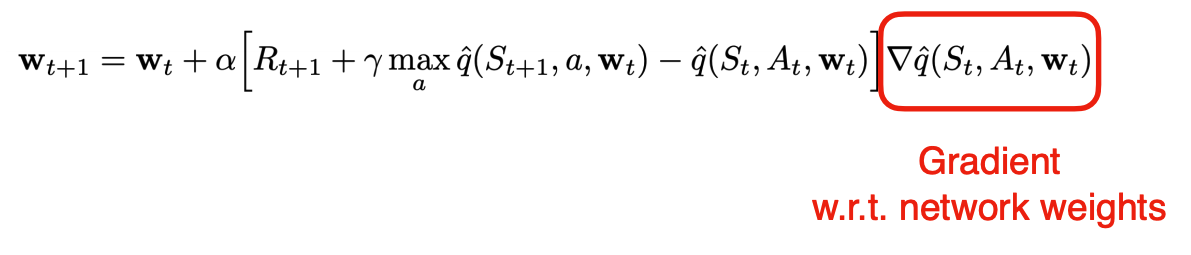

In [ ]:
Image('dqn_grad.png')

For Neural Networks, the TD target is our notion of "loss." Essentially, how should we update our $\hat{q}(s,a,w)$ if we have some error in our estimate (current $\hat{q}(s,a,w)$ of the value of this state+action, after we observe the real value of the state+action. The gradient in this case only depends on the predicted $\hat{q}(s,a,w)$ (not the target) that is grounded in the present, as you don't want to learn from "reversed time" and can only learn by updating our present values ($t = t$).  

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}
   \end{align}

There are many other loss functions you can use in neural networks, such as `Cross Entropy Loss`, `Hinge Loss`, `KL Divergence`, etc that just differ in how the loss is weighted or calculated, or some other theoretical constructs that are out of scope.

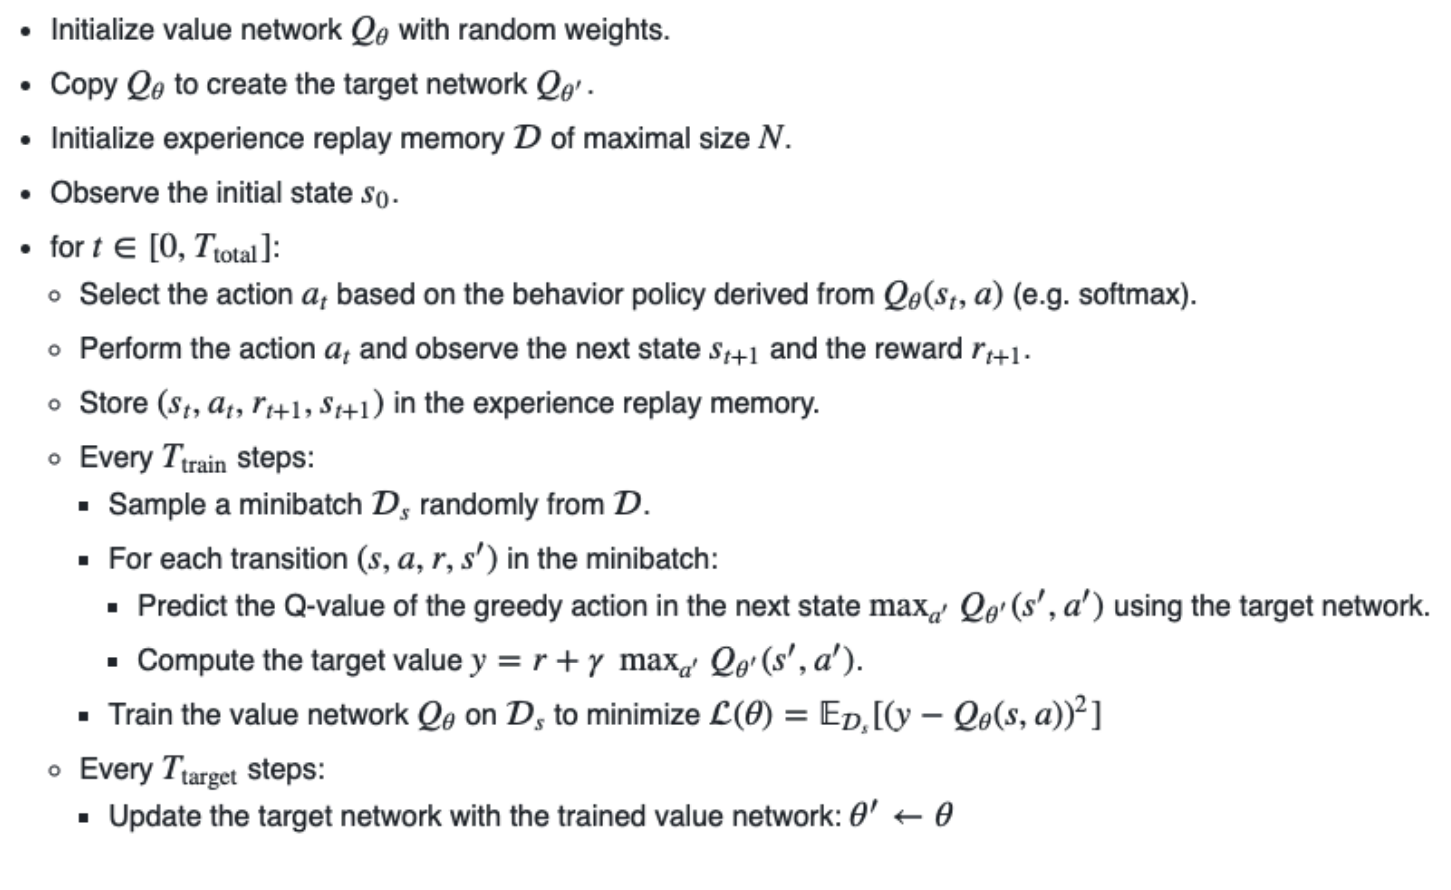

In [ ]:
Image('DQN.png')

## Replay Memory

It is expensive to play tons of episodes of the game, so we will store some of the agent's enviroment interactions and observed state transitions $(s, a, r, s')$ in a **replay buffer**. This is a return to the "look-up table" where we are storying $(s, a, r, s')$ in a big table to replay, essentially running the above DQN algorithm but over frozen, recorded experience instead of getting new $(s,a,r, s')$ from playing the environment. You can think of it as watching a replay of a basketball/DoTA 2 game to see mistakes and improve gameplay instead of playing another game, where there will be entirely new opponents (new $(s,a,r,s')$ not yet filled out). 

Empirically, this helps stabalize the neural networks' learning. You can keep updating just from experience, which is fast and efficient as you aren't interacting with the environment again. This reduces variance on $\hat{q}(s,a,r)$ for a specific $(s,a,r,s')$ pair, and helps the function converge. Basically, you can "get the most out of" some experience before moving on to new data. You can vary how much experience (batch size) you take before moving on.

There is no difference in how DQN works, just a change in where the $(s,a,r,s')$ you're getting to update the $\hat{q}(s,a,r)$. We typically sample from the stored experience randomly. 

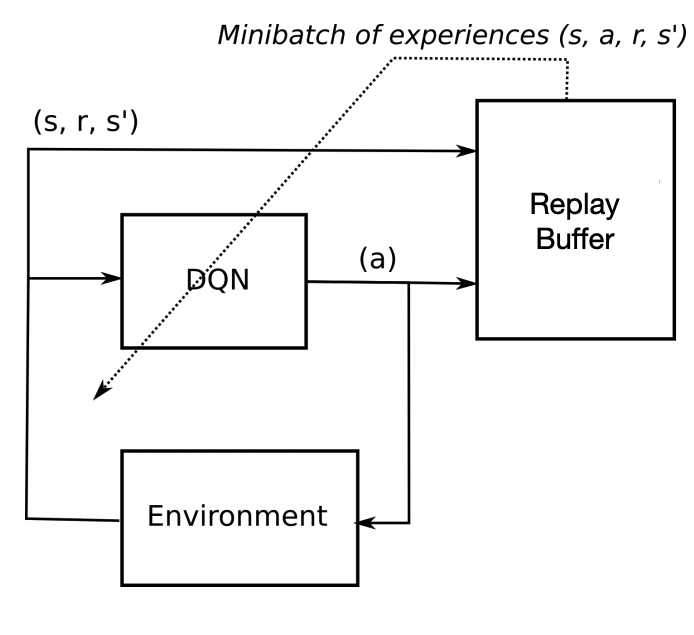

In [ ]:
Image('Replay.png')

# OpenAI Gym Cart Pole with DQN

Un-modified example for Pole Cart: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [ ]:
!apt-get install -y xvfb x11-utils

# install required python dependencies
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* pyglet==1.5.11

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,982 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 993 kB in 1s (1,138 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import matplotlib.pyplot as plt
#from IPython import display as ipythondisplay
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1')

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cart Pole source code: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

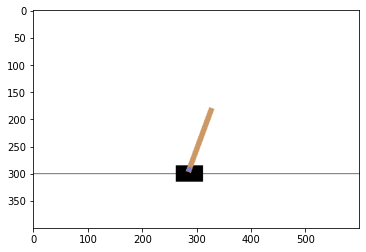

In [ ]:
import matplotlib.pyplot as plt
import gym
from IPython import display
%matplotlib inline

env = gym.make('CartPole-v1')
env.reset()

#rendering wont work in google colab
for i in range(25):
   plt.imshow(env.render(mode='rgb_array'))
   display.display(plt.gcf())    
   display.clear_output(wait=True)
   env.step(env.action_space.sample()) # take a random action

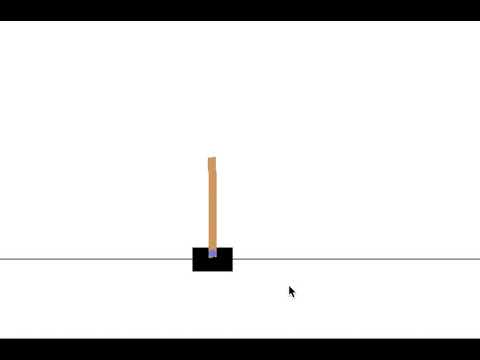

In [ ]:
YouTubeVideo('v_jOs7FK4Po')

In [ ]:
# convenient way to store the (s,a,r,s')

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity # change this hyperparamter to get more experience per memory batch
        self.memory = []
        self.position = 0

    def push(self, *args):
        # Saves a transition.
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args) 
        self.position = (self.position + 1) % self.capacity # indexing storage

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [ ]:
# Reading in the screen as individual states using a CNN

resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600

def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN().to(device) # instantiating our object, sends to gpu if using
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000) # sets the number of experiences in each memory. 

steps_done = 0
episode_durations = []

# custom select action function that has a decaying epsilon
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1) # picking the best action in that state
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long) # otherwise random

# function to help us display the improvement of the algorithm
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.5)  # pause a bit so that plots are updated
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    # sample from the memory we have saved up. 
    # so, we are only learning from the stored memory, not the environment.
    transitions = memory.sample(BATCH_SIZE) 
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward() # special pytorch functions to send loss backwards and update weights
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1) # clamp data to be [-1,1], as discussed in lecture.
    optimizer.step()

Actions are chosen either randomly or based on a policy, getting the next step sample from the gym environment. We record the results in the replay memory and also run optimization step on every iteration. Optimization picks a random batch from the replay memory to do training of the new policy. “Older” target_net is also used in optimization to compute the expected Q values; it is updated occasionally to keep it current.

In [ ]:
num_episodes = 300
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        # in optimize_model, we are replaying a batch sample from the memory.
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network
    # occasionally (when the mod step occurs) update our target neural network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

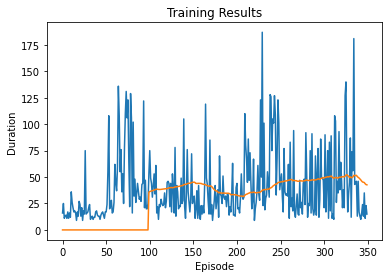

In [ ]:
plt.figure(2)
plt.clf()
durations_t = torch.tensor(episode_durations, dtype=torch.float)
plt.title('Training Results')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 100:
    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    plt.plot(means.numpy())

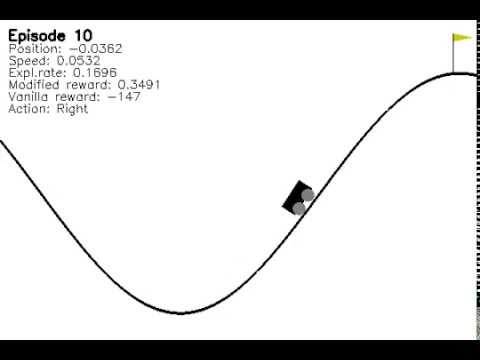

In [ ]:
# Other examples
YouTubeVideo('KFFdiBD9zCw')